In [1]:
import os
import glob
import yaml #pip install pandas pyyaml
import pandas as pd
import mysql.connector #pip install mysql-connector-python
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Folder path                       
folder_path = r"D:\data_driven\data"

# Month folders
month_name = [
    "2023-10","2023-11","2023-12","2024-01","2024-02","2024-03",
    "2024-04","2024-05","2024-06","2024-07","2024-08","2024-09","2024-10","2024-11"
]

# List to store all YAML data
records = []

# Loop through all month subfolders
for month in month_name:
    folder = os.path.join(folder_path, month)
    yaml_files = glob.glob(os.path.join(folder, "*.yaml"))

    for file_path in yaml_files:
        with open(file_path, "r") as file:
            data = yaml.safe_load(file)
            if data:
                # Append depending on type
                if isinstance(data, dict):
                    records.append(data)
                elif isinstance(data, list):
                    records.extend(data)
        print(f"Loaded {os.path.basename(file_path)} from {month}")


Loaded 2023-10-03_05-30-00.yaml from 2023-10
Loaded 2023-10-04_05-30-00.yaml from 2023-10
Loaded 2023-10-05_05-30-00.yaml from 2023-10
Loaded 2023-10-06_05-30-00.yaml from 2023-10
Loaded 2023-10-09_05-30-00.yaml from 2023-10
Loaded 2023-10-10_05-30-00.yaml from 2023-10
Loaded 2023-10-11_05-30-00.yaml from 2023-10
Loaded 2023-10-12_05-30-00.yaml from 2023-10
Loaded 2023-10-13_05-30-00.yaml from 2023-10
Loaded 2023-10-16_05-30-00.yaml from 2023-10
Loaded 2023-10-17_05-30-00.yaml from 2023-10
Loaded 2023-10-18_05-30-00.yaml from 2023-10
Loaded 2023-10-19_05-30-00.yaml from 2023-10
Loaded 2023-10-20_05-30-00.yaml from 2023-10
Loaded 2023-10-23_05-30-00.yaml from 2023-10
Loaded 2023-10-25_05-30-00.yaml from 2023-10
Loaded 2023-10-26_05-30-00.yaml from 2023-10
Loaded 2023-10-27_05-30-00.yaml from 2023-10
Loaded 2023-10-30_05-30-00.yaml from 2023-10
Loaded 2023-10-31_05-30-00.yaml from 2023-10
Loaded 2023-11-01_05-30-00.yaml from 2023-11
Loaded 2023-11-02_05-30-00.yaml from 2023-11
Loaded 202

In [3]:
# Convert all to one DataFrame
df1= pd.DataFrame(records)

print(f"\nTotal records loaded: {len(df1)}")
print(df1.head())



Total records loaded: 14200
       Ticker    close                 date    high      low    month    open  \
0        SBIN   602.95  2023-10-03 05:30:00   604.9   589.60  2023-10   596.6   
1  BAJFINANCE  7967.60  2023-10-03 05:30:00  7975.5  7755.00  2023-10  7780.8   
2       TITAN  3196.25  2023-10-03 05:30:00  3212.5  3114.40  2023-10  3148.8   
3         ITC   439.75  2023-10-03 05:30:00   442.9   439.25  2023-10   441.0   
4         TCS  3513.85  2023-10-03 05:30:00  3534.2  3480.10  2023-10  3534.2   

     volume  
0  15322196  
1    944555  
2   1007308  
3   7481883  
4   1948148  


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14200 entries, 0 to 14199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  14200 non-null  object 
 1   close   14200 non-null  float64
 2   date    14200 non-null  object 
 3   high    14200 non-null  float64
 4   low     14200 non-null  float64
 5   month   14200 non-null  object 
 6   open    14200 non-null  float64
 7   volume  14200 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 887.6+ KB


In [5]:
def get_connection():
    return mysql.connector.connect(
        host="localhost",
        user="root",
        password="0007"
    )

In [7]:
# Establish connection
conn = get_connection()

# Create a cursor
cursor = conn.cursor()

# Create database
cursor.execute("CREATE DATABASE DATA")
print("Database 'DATA' created successfully!")

# Close connection
cursor.close()
conn.close()


Database 'DATA' created successfully!


In [8]:
# Connect to MySQL
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")

# Create table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS MARKET (
        Ticker VARCHAR(50),
        close DECIMAL(10,2),
        date DATETIME,
        high DECIMAL(10,2),
        low DECIMAL(10,2),
        month VARCHAR(10),
        open DECIMAL(10,2),
        volume INT
    )
""")

# Commit and close
conn.commit()
cursor.close()
conn.close()

print("Table 'MARKET' created successfully!")

Table 'MARKET' created successfully!


In [9]:
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")
# Loop through DataFrame rows
for _, row in df1.iterrows():
    cursor.execute("""
        INSERT INTO MARKET (Ticker, close, date, high, low, month,open,volume)
        VALUES (%s, %s, %s, %s, %s,%s, %s,%s)
    """, (
        row.get("Ticker"),
        row.get("close"),
        row.get("date"),
        row.get("high"),
        row.get("low"),
        row.get("month"),
        row.get("open"),
        row.get("volume")
    ))

# Commit changes and close connection
conn.commit()
cursor.close()
conn.close()

print("Data inserted successfully into 'MARKET'!")


Data inserted successfully into 'MARKET'!


In [10]:
# Folder to save CSV files
output_folder =os.path.join(folder_path,"output_csv") #r"D:\data_driven\output_csv"
os.makedirs(output_folder, exist_ok=True)
conn = get_connection()
cursor = conn.cursor()
cursor.execute("USE DATA")

# Step 1: Get distinct tickers
cursor.execute("SELECT DISTINCT Ticker FROM MARKET")
companies = [row[0] for row in cursor.fetchall()]  # flatten to list
print("Tickers found:", companies)

# Step 2: Loop through each ticker, fetch data, and save as CSV
for ticker in companies:
    print(f"Processing {ticker}...")

    cursor.execute("""
        SELECT Ticker, close, date, high, low, month, open,volume
        FROM MARKET
        WHERE Ticker = %s
    """, (ticker,))
    rows = cursor.fetchall()

    # Convert to DataFrame
    df = pd.DataFrame(rows, columns=["Ticker", "close", "date", "high", "low", "month", "open","volume"])

    # Step 3: Save to CSV
    csv_path = os.path.join(output_folder, f"{ticker}.csv")
    df.to_csv(csv_path, index=False)

    print(f"Saved: {csv_path}")

# Close connection
cursor.close()
conn.close()

print("✅ All ticker data exported to CSV successfully!")


Tickers found: ['SBIN', 'BAJFINANCE', 'TITAN', 'ITC', 'TCS', 'LT', 'TATACONSUM', 'RELIANCE', 'HCLTECH', 'JSWSTEEL', 'ULTRACEMCO', 'POWERGRID', 'INFY', 'TRENT', 'BHARTIARTL', 'TATAMOTORS', 'WIPRO', 'TECHM', 'NTPC', 'HINDUNILVR', 'APOLLOHOSP', 'M&M', 'GRASIM', 'ICICIBANK', 'ADANIENT', 'ADANIPORTS', 'BEL', 'BAJAJFINSV', 'EICHERMOT', 'COALINDIA', 'MARUTI', 'INDUSINDBK', 'ASIANPAINT', 'TATASTEEL', 'HDFCLIFE', 'DRREDDY', 'SUNPHARMA', 'KOTAKBANK', 'SHRIRAMFIN', 'NESTLEIND', 'ONGC', 'CIPLA', 'BPCL', 'BRITANNIA', 'SBILIFE', 'HINDALCO', 'HEROMOTOCO', 'AXISBANK', 'HDFCBANK', 'BAJAJ-AUTO']
Processing SBIN...
Saved: D:\data_driven\data\output_csv\SBIN.csv
Processing BAJFINANCE...
Saved: D:\data_driven\data\output_csv\BAJFINANCE.csv
Processing TITAN...
Saved: D:\data_driven\data\output_csv\TITAN.csv
Processing ITC...
Saved: D:\data_driven\data\output_csv\ITC.csv
Processing TCS...
Saved: D:\data_driven\data\output_csv\TCS.csv
Processing LT...
Saved: D:\data_driven\data\output_csv\LT.csv
Processing TA

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [12]:
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

list_val=[]
DATE_COL = 'date'
CLOSE_COL = 'close'

for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()
    df_cleaned = df2[[DATE_COL, CLOSE_COL]].copy()
    df_cleaned.rename(columns={DATE_COL: 'Date', CLOSE_COL: 'Close'}, inplace=True)
    df_cleaned['Ticker'] = ticker
    list_val.append(df_cleaned)

combined_df = pd.concat(list_val, axis=0, ignore_index=True)
combined_df.to_csv("combined_stock_data.csv", index=False)


In [13]:
list_val

[                    Date    Close    Ticker
 0    2023-10-03 05:30:00  2387.25  ADANIENT
 1    2023-10-04 05:30:00  2464.95  ADANIENT
 2    2023-10-05 05:30:00  2466.35  ADANIENT
 3    2023-10-06 05:30:00  2478.10  ADANIENT
 4    2023-10-09 05:30:00  2442.60  ADANIENT
 ..                   ...      ...       ...
 279  2024-11-14 05:30:00  2826.80  ADANIENT
 280  2024-11-18 05:30:00  2818.70  ADANIENT
 281  2024-11-19 05:30:00  2821.50  ADANIENT
 282  2024-11-21 05:30:00  2183.65  ADANIENT
 283  2024-11-22 05:30:00  2228.00  ADANIENT
 
 [284 rows x 3 columns],
                     Date    Close      Ticker
 0    2023-10-03 05:30:00   831.40  ADANIPORTS
 1    2023-10-04 05:30:00   824.60  ADANIPORTS
 2    2023-10-05 05:30:00   825.20  ADANIPORTS
 3    2023-10-06 05:30:00   830.75  ADANIPORTS
 4    2023-10-09 05:30:00   790.05  ADANIPORTS
 ..                   ...      ...         ...
 279  2024-11-14 05:30:00  1264.55  ADANIPORTS
 280  2024-11-18 05:30:00  1279.30  ADANIPORTS
 281  2024

In [14]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14200 entries, 0 to 14199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    14200 non-null  object 
 1   Close   14200 non-null  float64
 2   Ticker  14200 non-null  object 
dtypes: float64(1), object(2)
memory usage: 332.9+ KB


In [15]:
v=combined_df['Ticker'].unique()
len(v)

50

In [16]:

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['Close'] = pd.to_numeric(combined_df['Close'], errors='coerce')
combined_df = combined_df.dropna(subset=['Close'])
combined_df = combined_df.sort_values(by=['Ticker', 'Date'])

combined_df['Daily_Return'] = combined_df.groupby('Ticker')['Close'].pct_change()
returns_df = combined_df.dropna(subset=['Daily_Return'])
volatility = returns_df.groupby('Ticker')['Daily_Return'].std().reset_index()
volatility.columns = ['Ticker', 'Volatility']
top_10_volatility = volatility.sort_values(by='Volatility', ascending=False).head(10)

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(top_10_volatility['Ticker'], top_10_volatility['Volatility'], color='teal')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Returns)')
plt.title('Top 10 Most Volatile Stocks')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('top_10_volatility_bar_chart.png')


Top 5 Stocks Based on Cumulative Return:
47         TRENT
8            BEL
30           M&M
5     BAJAJ-AUTO
9     BHARTIARTL
Name: Ticker, dtype: object


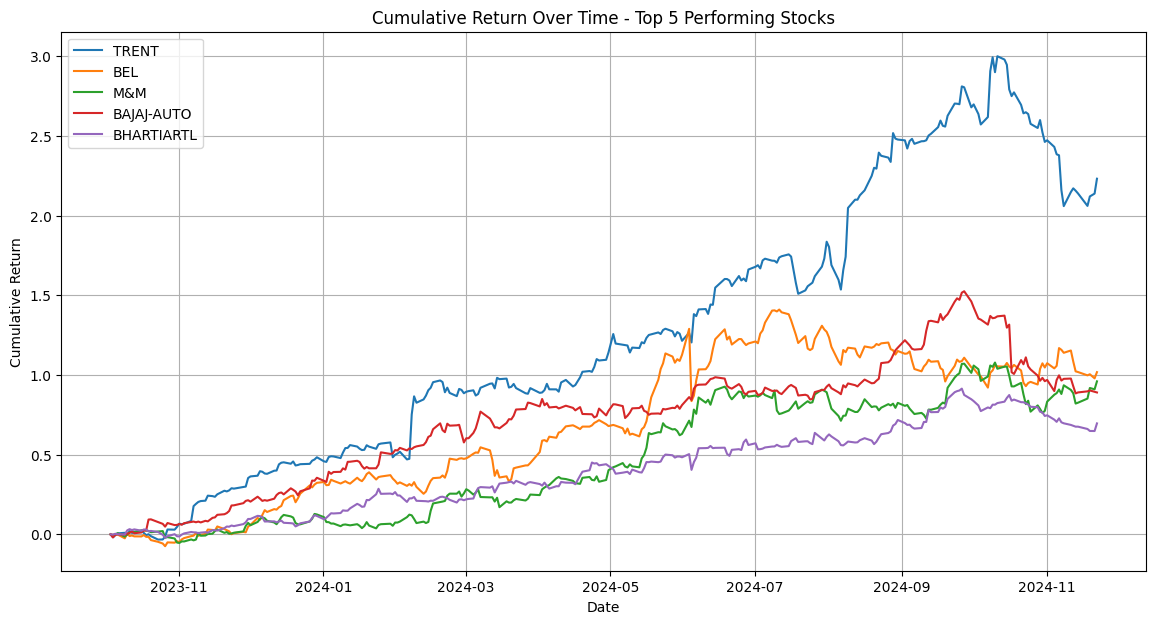

In [17]:


# --- READ COMBINED CSV FILES ---
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

list_val = []
DATE_COL = 'date'
CLOSE_COL = 'close'

for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()

    df_cum = df2[[DATE_COL, CLOSE_COL]].copy()
    df_cum.rename(columns={DATE_COL: 'Date', CLOSE_COL: 'Close'}, inplace=True)
    df_cum['Ticker'] = ticker

    list_val.append(df_cum)

cum_df = pd.concat(list_val, axis=0, ignore_index=True)

# Sort by date (important!)
cum_df['Date'] = pd.to_datetime(cum_df['Date'])
cum_df.sort_values(by=['Ticker', 'Date'], inplace=True)

# Calculate cumulative return
cum_df['Start_Close'] = cum_df.groupby("Ticker")['Close'].transform('first')
cum_df['Cumulative_Return'] = (cum_df['Close'] / cum_df['Start_Close']) - 1
cum_df['Cumulative_Return_Percent'] = cum_df['Cumulative_Return'] * 100

# ------------- SELECT TOP 5 STOCKS -----------------

# Get last cumulative return value per stock
final_cum = cum_df.groupby("Ticker")['Cumulative_Return'].last().reset_index()

# Pick top 5 performing stocks
top5_tickers = final_cum.sort_values(by='Cumulative_Return', ascending=False).head(5)['Ticker']
print("Top 5 Stocks Based on Cumulative Return:")
print(top5_tickers)

# Filter data for only these 5 stocks
top5_df = cum_df[cum_df['Ticker'].isin(top5_tickers)]

# ------------- PLOT CUMULATIVE RETURNS --------------

plt.figure(figsize=(14, 7))

for ticker in top5_tickers:
    df_plot = top5_df[top5_df['Ticker'] == ticker]
    plt.plot(df_plot['Date'], df_plot['Cumulative_Return'], label=ticker)

plt.title("Cumulative Return Over Time - Top 5 Performing Stocks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()



Average Sector-wise Returns:
sector
RETAILING          113.305399
DEFENCE            101.760057
TELECOM             69.599049
POWER               60.184095
ALUMINIUM           58.976655
TEXTILES            48.779614
AUTOMOBILES         39.867951
CEMENT              36.970945
PHARMACEUTICALS     35.659695
ENERGY              35.586945
MINING              25.676361
INSURANCE           25.547514
FMCG                22.811076
SOFTWARE            22.158497
MISCELLANEOUS       21.845102
STEEL               19.217125
BANKING             19.142631
ENGINEERING         17.253722
FINANCE             11.576063
FOOD & TOBACCO       4.321734
PAINTS             -21.935046
Name: yearly_return, dtype: float64


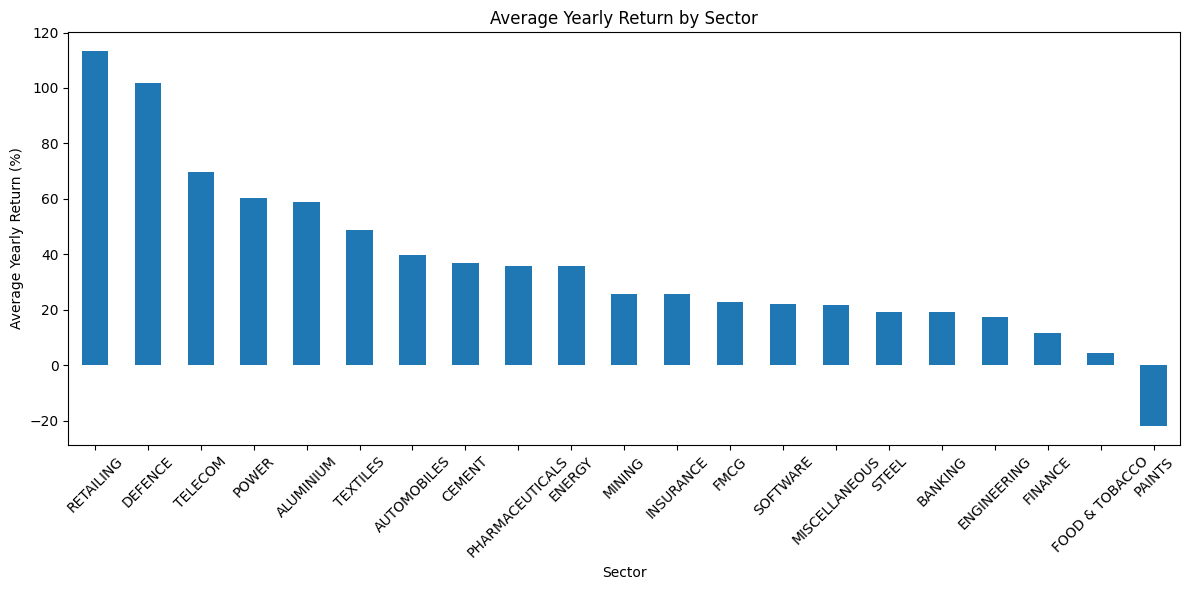

In [19]:

# ----------------------------
# 1. Load sector mapping
# ----------------------------
sector_map = pd.read_csv(r"D:\data_driven\.dds\Sector_data - Sheet1.csv")  # stock, sector

# ----------------------------
# 2. Load combined stock price dataset
# ----------------------------
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))

sect_tick=[]
all_daa=[]
for filename in all_files:
    df2 = pd.read_csv(filename)
    ticker = os.path.splitext(os.path.basename(filename))[0].upper()
    df_cleaned = df2.copy()
    all_daa.append(df_cleaned)
    sect_tick.append(ticker)

combined_df = pd.concat(all_daa, axis=0, ignore_index=True)
combined_df.to_csv("sector_ticker.csv", index=False)  # date, stock, close
combined_df['date'] = pd.to_datetime(combined_df['date'])

n=pd.DataFrame(sect_tick,columns=["Ticker"])
sector_map["COMPANY"]=n["Ticker"]
sector_map.rename(columns={"COMPANY":"Ticker"},inplace=True)
# ----------------------------
# 3. Calculate yearly return for each stock
# ----------------------------
# Get first and last price for each stock
first_last = combined_df.sort_values('date').groupby('Ticker').agg(
    first_price=('close', 'first'),
    last_price=('close', 'last')
)

first_last['yearly_return'] = (first_last['last_price'] - first_last['first_price']) / first_last['first_price'] * 100
first_last.reset_index(inplace=True)

# ----------------------------
# 4. Merge sector data
# ----------------------------
merged = pd.merge(first_last, sector_map, on='Ticker', how='left')

# ----------------------------
# 5. Calculate average yearly return by sector
# ----------------------------
sector_perf = merged.groupby('sector')['yearly_return'].mean().sort_values(ascending=False)

print("\nAverage Sector-wise Returns:")
print(sector_perf)

# ----------------------------
# 6. Plot bar chart
# ----------------------------
plt.figure(figsize=(12,6))
sector_perf.plot(kind='bar')

plt.title("Average Yearly Return by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Yearly Return (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
folder_path_1=r"D:\data_driven\data\Sector_data - Sheet1.csv"
def avg_year_returns(folder_path,folder_path_1):
    sector_map = pd.read_csv(folder_path_1)  # stock, sector
    output_folder = os.path.join(folder_path, "output_csv")
    all_files = glob.glob(os.path.join(output_folder, "*.csv"))
    sect_tick=[]
    all_daa=[]
    for filename in all_files:
        df2 = pd.read_csv(filename)
        ticker = os.path.splitext(os.path.basename(filename))[0].upper()
        df_cleaned = df2.copy()
        all_daa.append(df_cleaned)
        sect_tick.append(ticker)
    combined_df = pd.concat(all_daa, axis=0, ignore_index=True)
    combined_df.to_csv("sector_ticker.csv", index=False)  # date, stock, clos
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    n=pd.DataFrame(sect_tick,columns=["Ticker"])
    sector_map["COMPANY"]=n["Ticker"]
    sector_map.rename(columns={"COMPANY":"Ticker"},inplace=True)

    first_last = combined_df.sort_values('date').groupby('Ticker').agg(
        first_price=('close', 'first'),
        last_price=('close', 'last'))
    first_last['yearly_return'] = (first_last['last_price'] - first_last['first_price']) / first_last['first_price'] * 100
    first_last.reset_index(inplace=True)
    merged = pd.merge(first_last, sector_map, on='Ticker', how='left')
    sector_perf = merged.groupby('sector')['yearly_return'].mean().sort_values(ascending=False)
    print("\nAverage Sector-wise Returns:")
    print(sector_perf)
    plt.figure(figsize=(12,6))
    sector_perf.plot(kind='bar')
    plt.title("Average Yearly Return by Sector")
    plt.xlabel("Sector")
    plt.ylabel("Average Yearly Return (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [21]:
# --- READ ALL STOCK CSV FILES ---
def stock_correlation(folder_path):
    output_folder = os.path.join(folder_path, "output_csv")
    all_files = glob.glob(os.path.join(output_folder, "*.csv"))

    stock_dict = {}   # Ticker → its closing prices

    for filename in all_files:
        df = pd.read_csv(filename)
        
        # Extract ticker name from filename
        ticker = os.path.splitext(os.path.basename(filename))[0].upper()

        # Clean dataframe: convert date & sort
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Set date as index
        df = df.set_index('date')

        # Keep only the Close column
        stock_dict[ticker] = df['close']

    # Combine all stocks into a single DataFrame by date
    combined_df = pd.DataFrame(stock_dict)

    # Compute correlation matrix
    corr_matrix = combined_df.corr()

    print("\n🔍 STOCK PRICE CORRELATION MATRIX:")
    print(corr_matrix)

    # ---------------- PLOT HEATMAP -------------------
    plt.figure(figsize=(12, 8))
    plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Correlation Coefficient")

    # Add ticks and labels
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)

    plt.title("Stock Price Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    return corr_matrix


In [22]:
output_folder = os.path.join(folder_path, "output_csv")
all_files = glob.glob(os.path.join(output_folder, "*.csv"))


In [23]:
all_daa=[]
for filename in all_files:
    df2 = pd.read_csv(filename)
    df_cleaned = df2.copy()
    all_daa.append(df_cleaned)
combined_df = pd.concat(all_daa, axis=0, ignore_index=True)

In [24]:
combined_df

,Ticker,close,date,high,low,month,open,volume
0,ADANIENT,2387.25,2023-10-03 05:30:00,2424.90,2372.00,2023-10,2418.00,2019899
1,ADANIENT,2464.95,2023-10-04 05:30:00,2502.75,2392.25,2023-10,2402.20,2857377
2,ADANIENT,2466.35,2023-10-05 05:30:00,2486.50,2446.40,2023-10,2477.95,1132455
3,ADANIENT,2478.10,2023-10-06 05:30:00,2514.95,2466.05,2023-10,2466.35,1510035
4,ADANIENT,2442.60,2023-10-09 05:30:00,2459.70,2411.30,2023-10,2440.00,1408224
...,...,...,...,...,...,...,...,...
14195,WIPRO,566.70,2024-11-14 05:30:00,574.55,564.20,2024-11,568.95,4891760
14196,WIPRO,552.85,2024-11-18 05:30:00,566.70,540.30,2024-11,566.70,7644882
14197,WIPRO,562.00,2024-11-19 05:30:00,569.80,554.70,2024-11,556.00,6459889
14198,WIPRO,557.15,2024-11-21 05:30:00,567.60,555.30,2024-11,562.00,5836304


In [25]:
combined_df.groupby(["Ticker","month"])["close"].agg("mean")

Ticker    month  
ADANIENT  2023-10    2393.570000
          2023-11    2237.385714
          2023-12    2830.115000
          2024-01    3002.256818
          2024-02    3221.714286
                        ...     
WIPRO     2024-07     533.552273
          2024-08     510.292857
          2024-09     534.233333
          2024-10     541.559091
          2024-11     561.117857
Name: close, Length: 700, dtype: float64

In [26]:
all_data = []

    # Read all CSV files and combine
for file in all_files:
    ticker = os.path.splitext(os.path.basename(file))[0].upper()
    df = pd.read_csv(file)

    df['date'] = pd.to_datetime(df['date'])
    df['Ticker'] = ticker
    all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)


In [31]:
monthly = combined_df.sort_values('date').groupby(['Ticker', 'Month'])['close'].agg(['first', 'last'])
monthly

first     last
Ticker   Month                    
ADANIENT 2023-10  2387.25  2294.65
         2023-11  2217.30  2358.55
         2023-12  2362.70  2848.95
         2024-01  2917.20  3142.00
         2024-02  3153.50  3285.40
...                   ...      ...
WIPRO    2024-07   527.35   522.00
         2024-08   521.55   538.40
         2024-09   532.45   541.45
         2024-10   546.75   551.80
         2024-11   551.35   571.65

[700 rows x 2 columns]

In [28]:

    # ---- Extract month in YYYY-MM format ----
combined_df['Month'] = combined_df['date'].dt.to_period('M').astype(str)

    # ---- Calculate Monthly Returns ----
monthly = combined_df.sort_values('date').groupby(['Ticker', 'Month'])['close'].agg(['first', 'last'])

monthly['Monthly_Return'] = ((monthly['last'] - monthly['first']) / monthly['first']) * 100
monthly.reset_index(inplace=True)

In [29]:
monthly

,Ticker,Month,first,last,Monthly_Return
0,ADANIENT,2023-10,2387.25,2294.65,-3.878940
1,ADANIENT,2023-11,2217.30,2358.55,6.370360
2,ADANIENT,2023-12,2362.70,2848.95,20.580268
3,ADANIENT,2024-01,2917.20,3142.00,7.706019
4,ADANIENT,2024-02,3153.50,3285.40,4.182654
...,...,...,...,...,...
695,WIPRO,2024-07,527.35,522.00,-1.014506
696,WIPRO,2024-08,521.55,538.40,3.230754
697,WIPRO,2024-09,532.45,541.45,1.690300
698,WIPRO,2024-10,546.75,551.80,0.923640


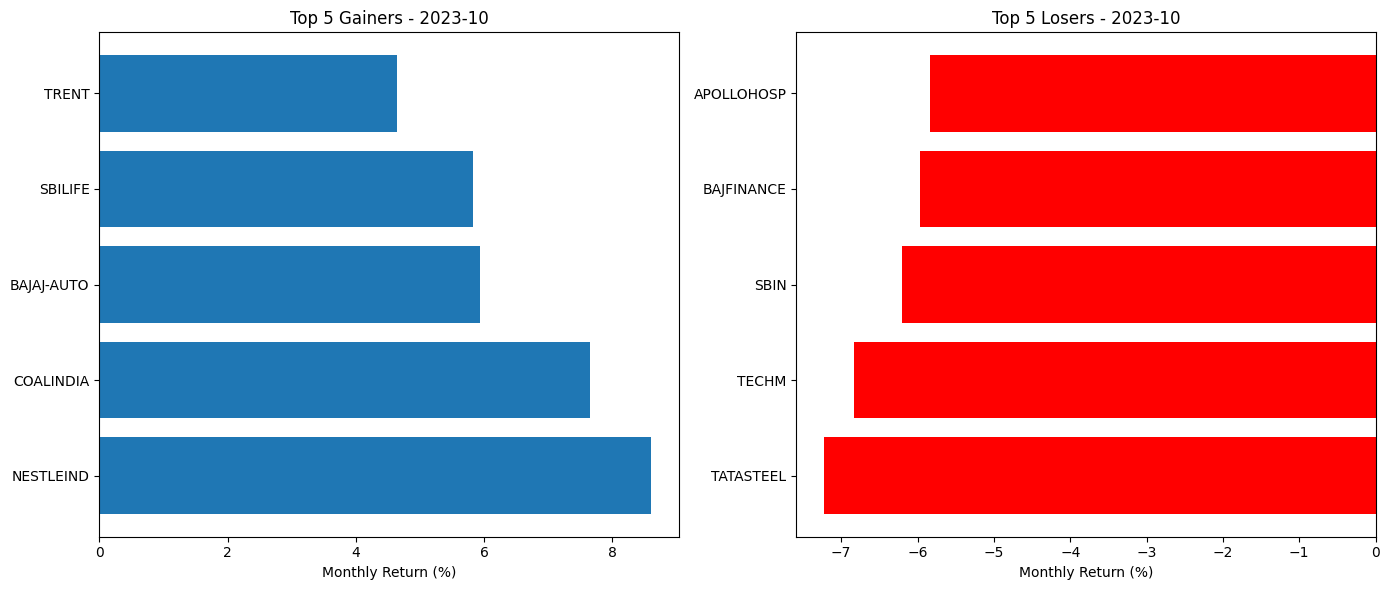

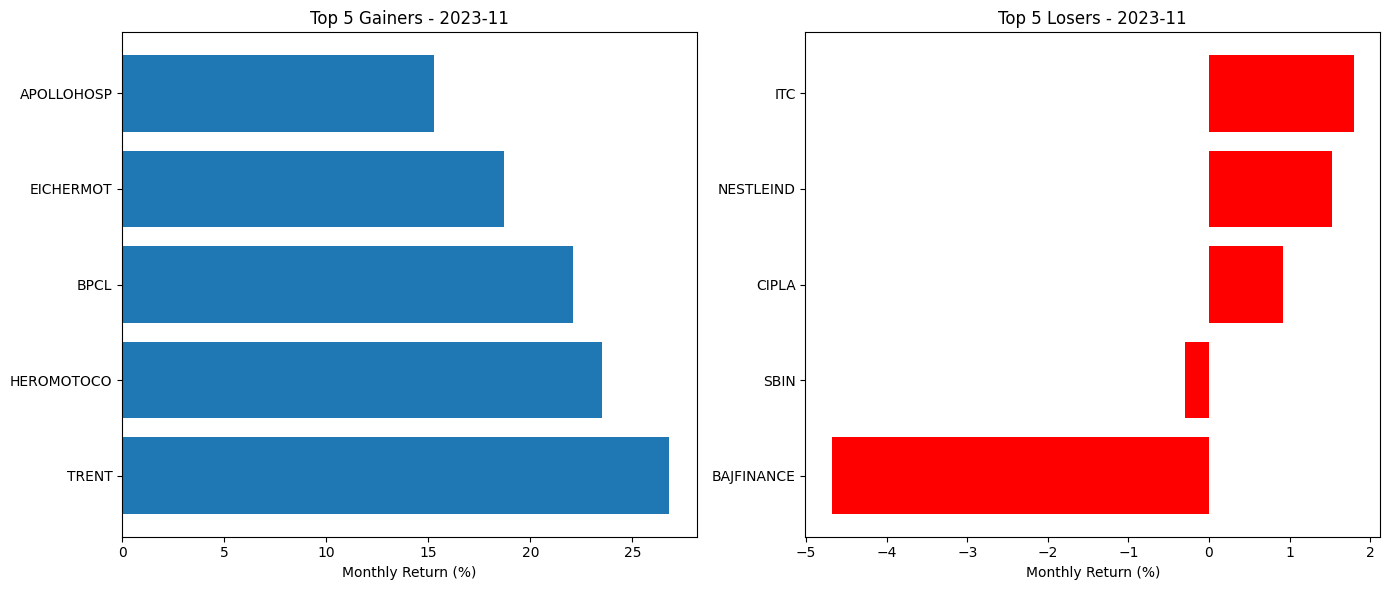

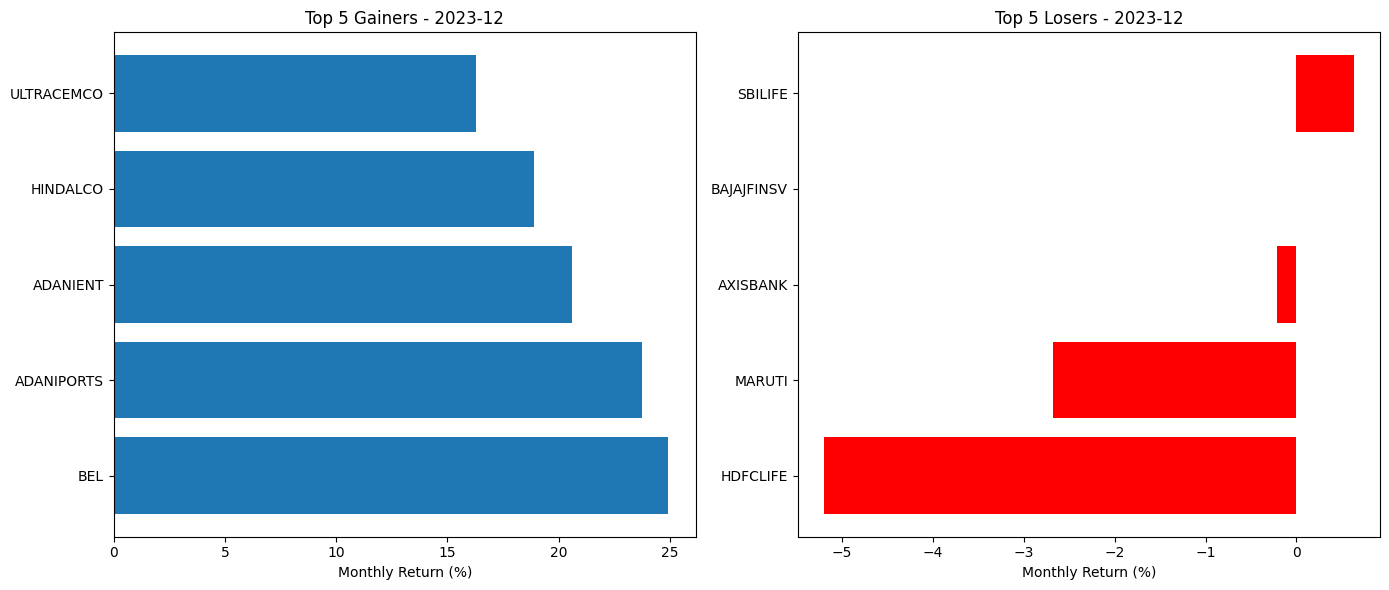

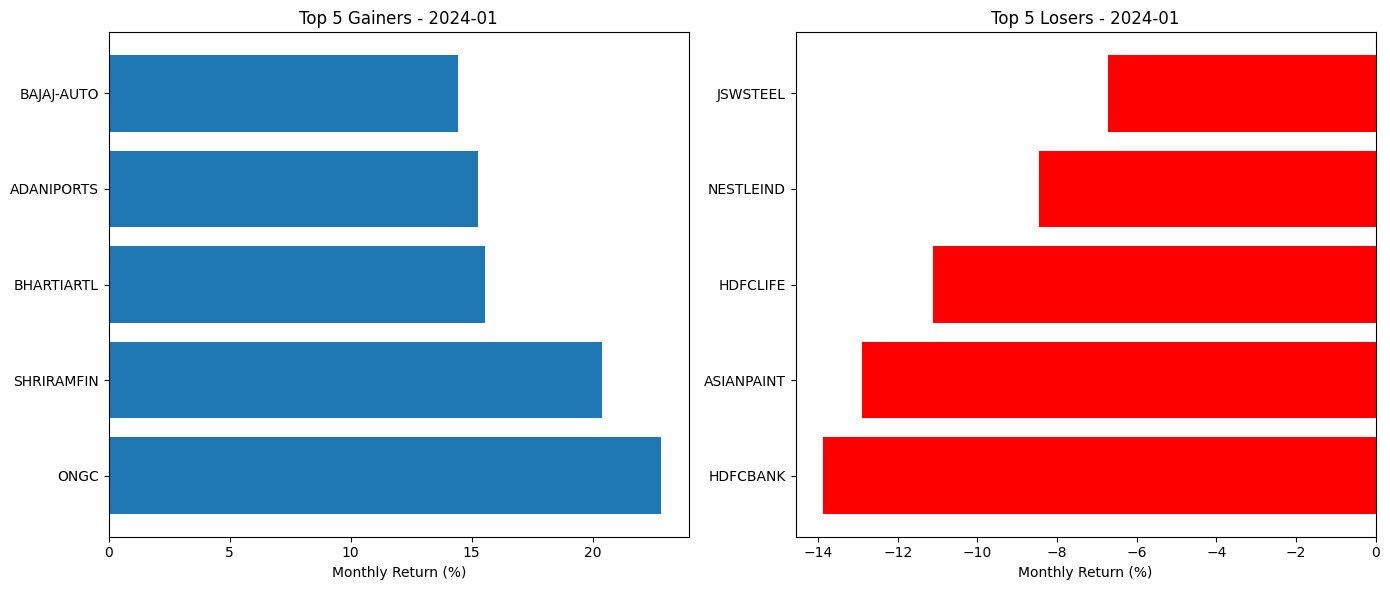

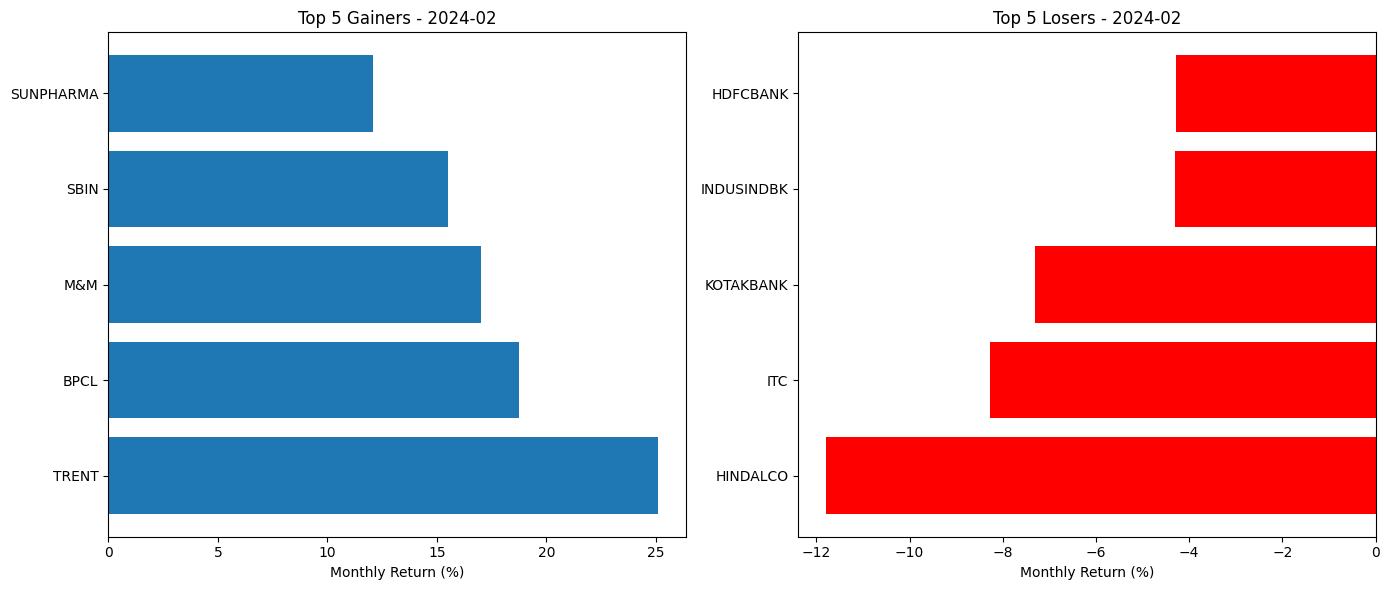

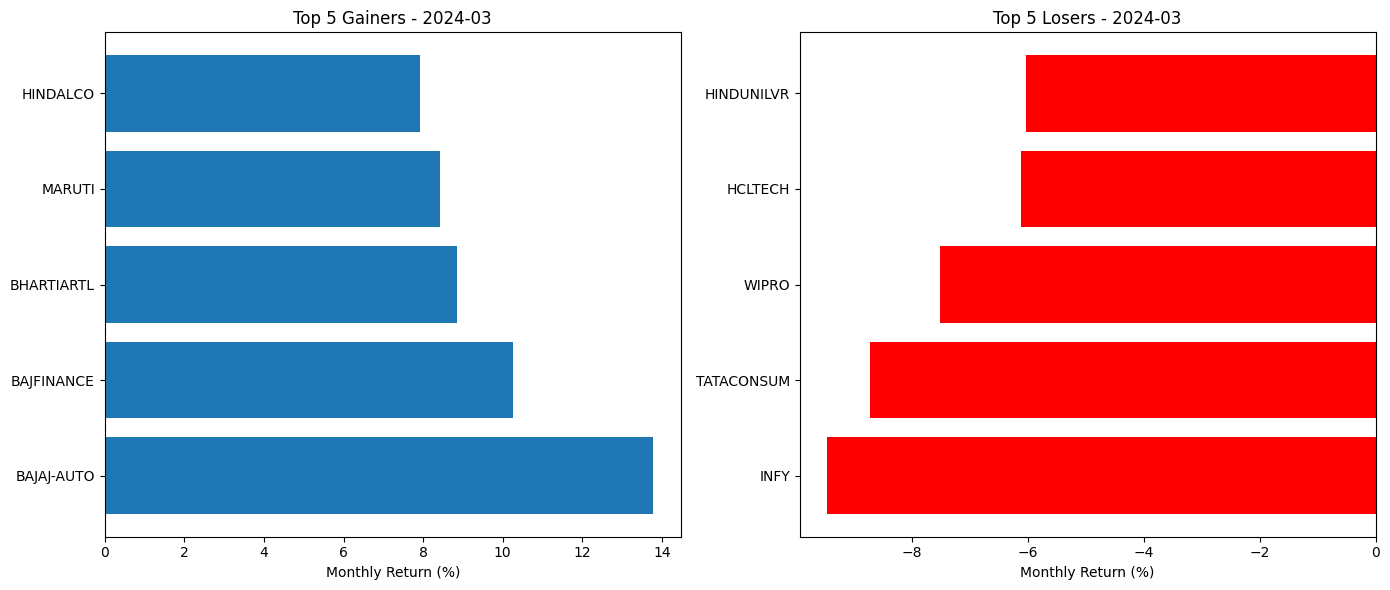

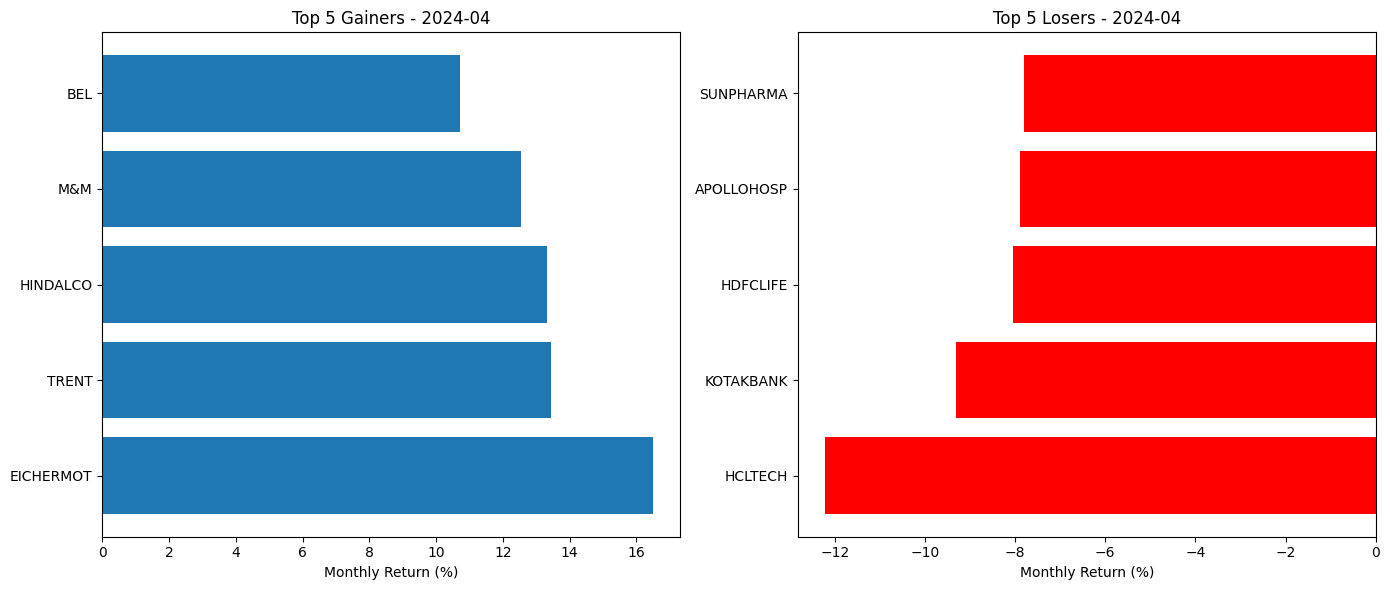

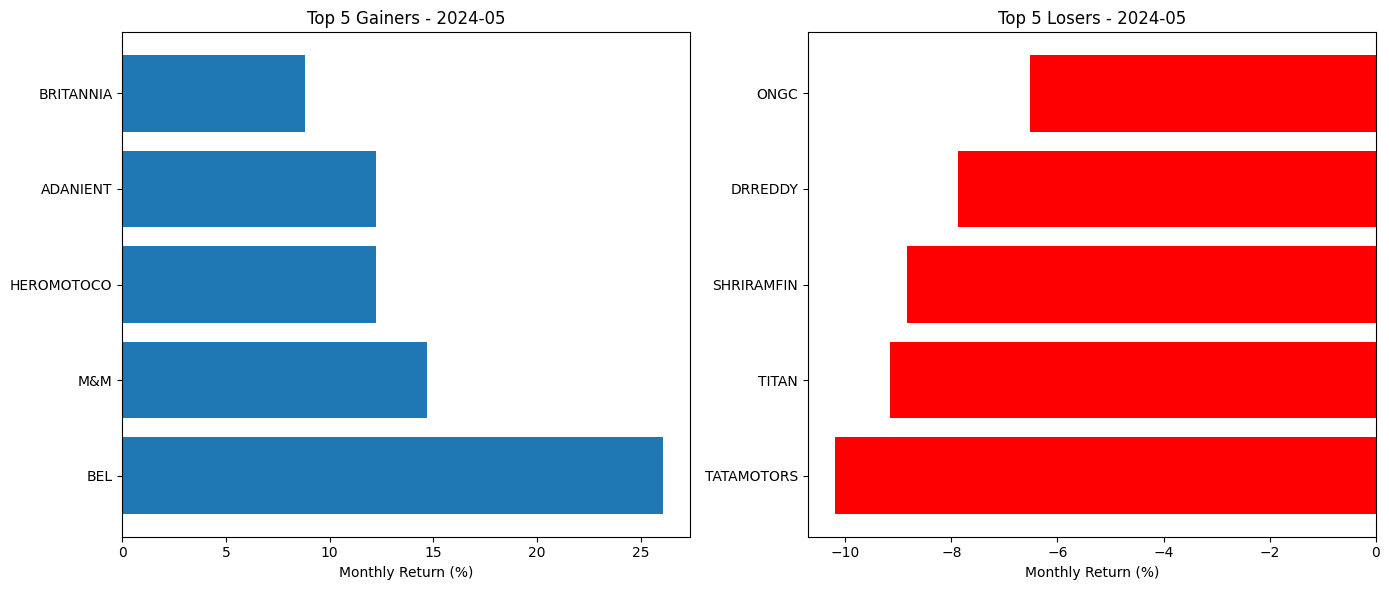

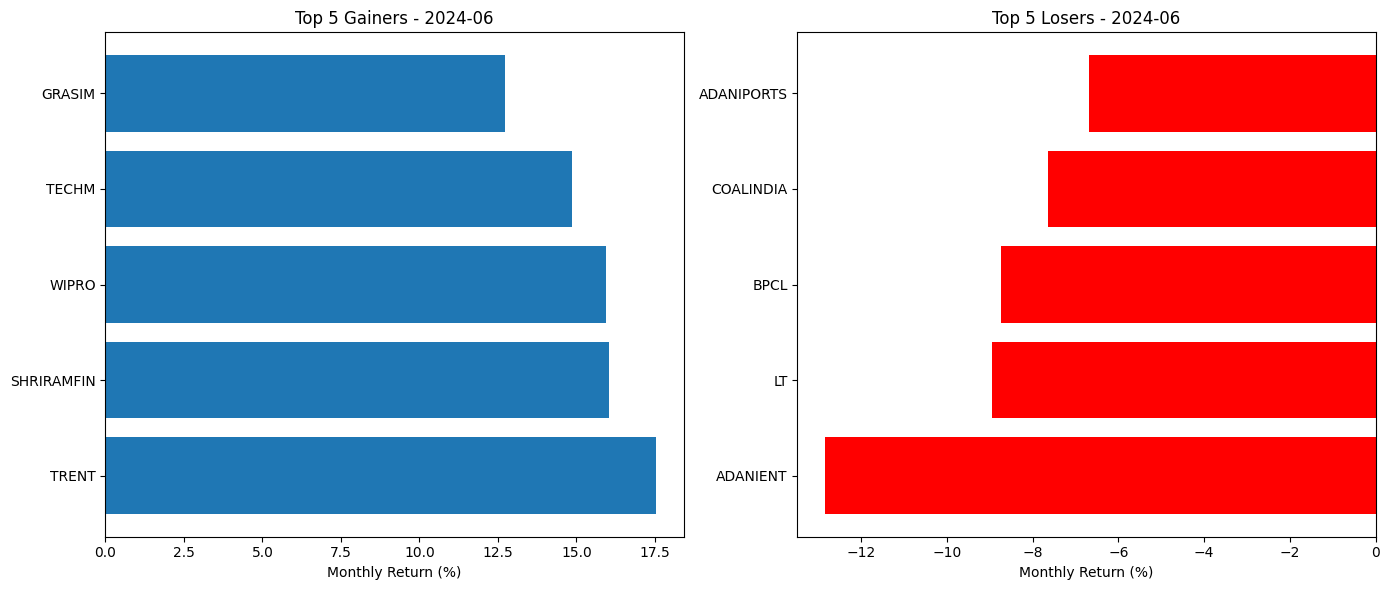

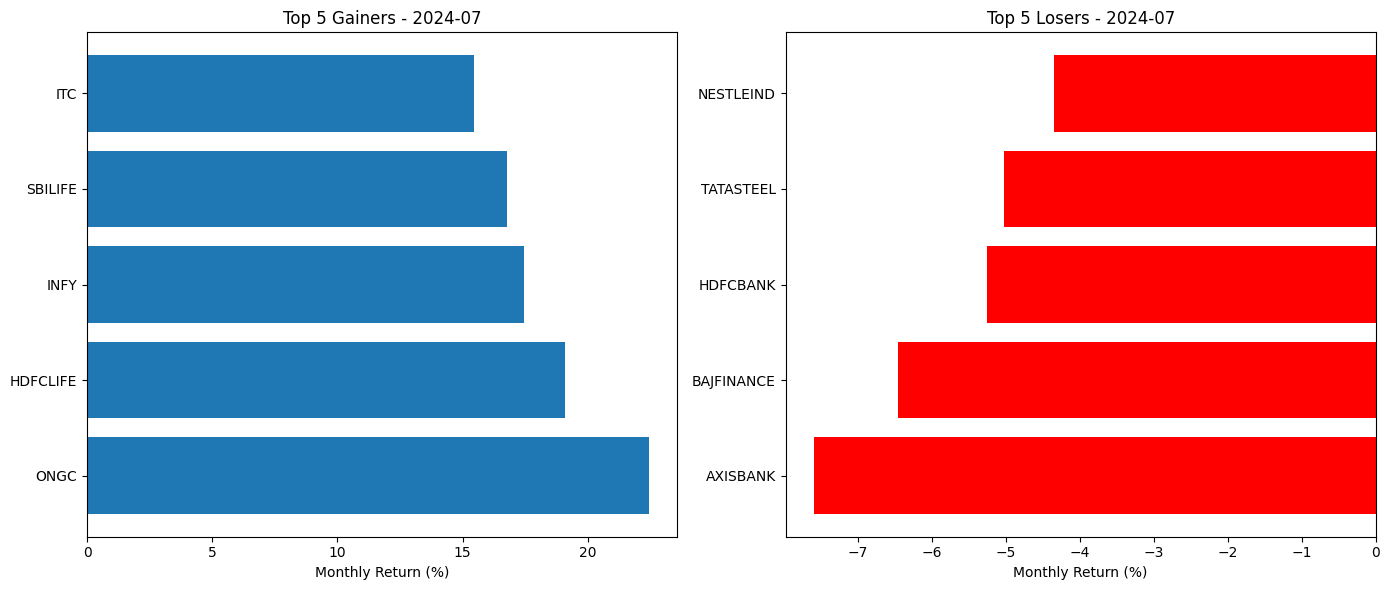

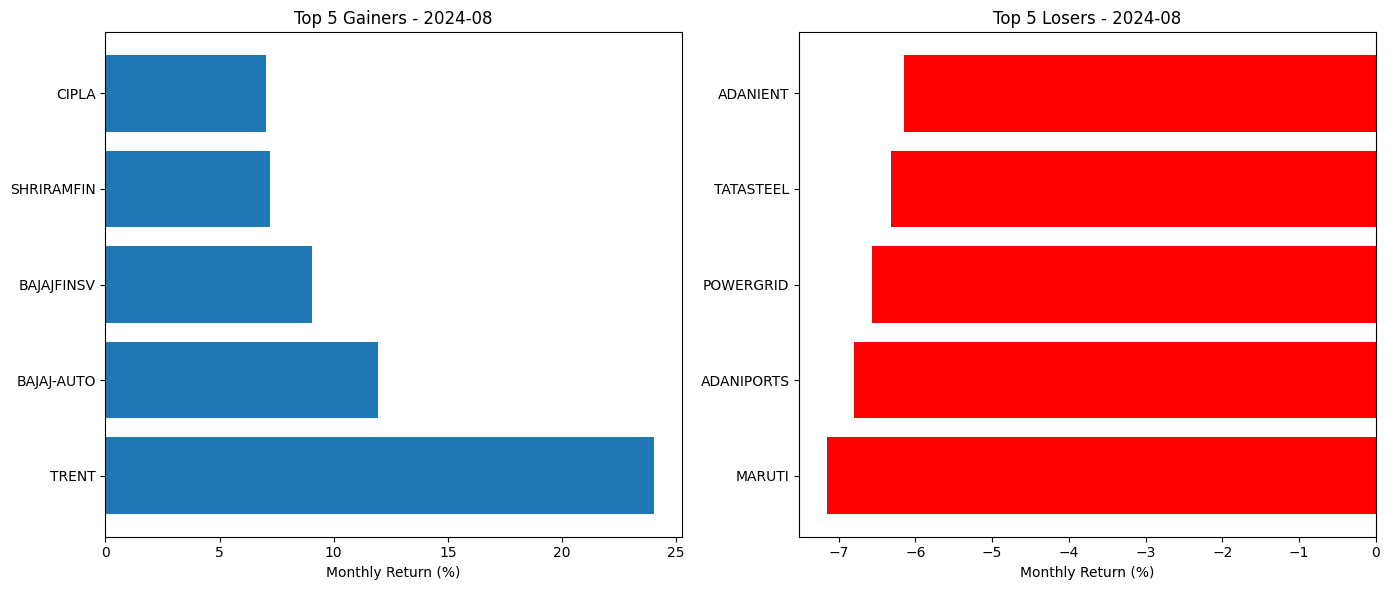

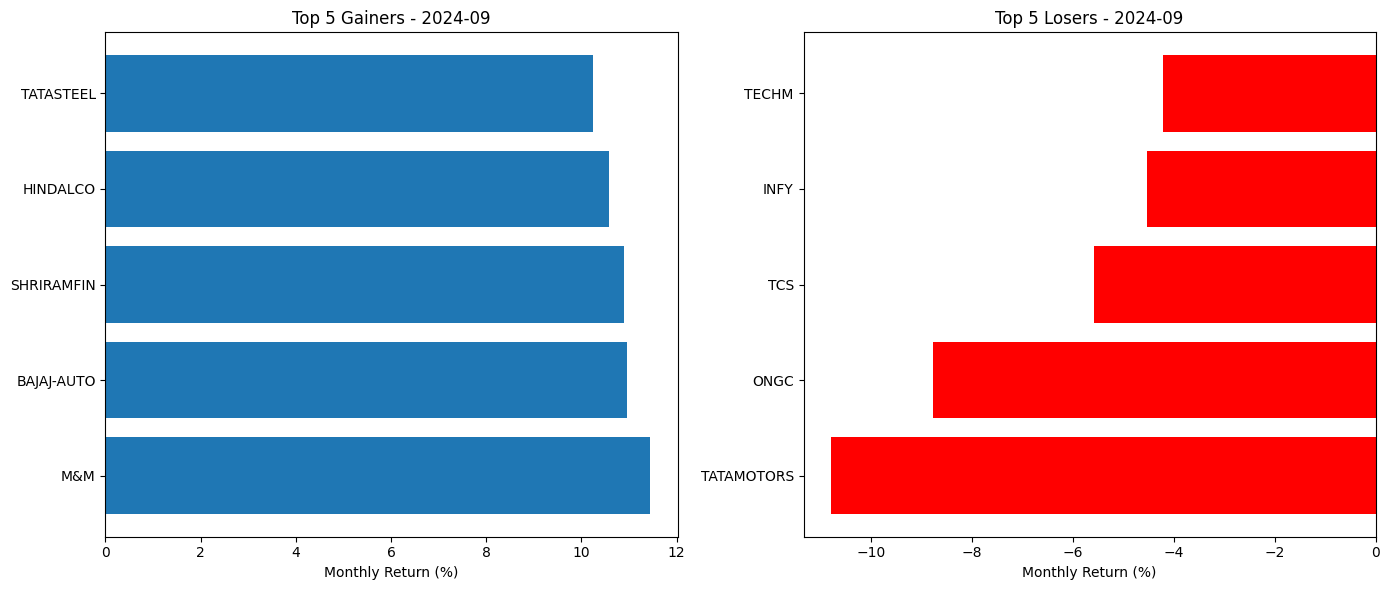

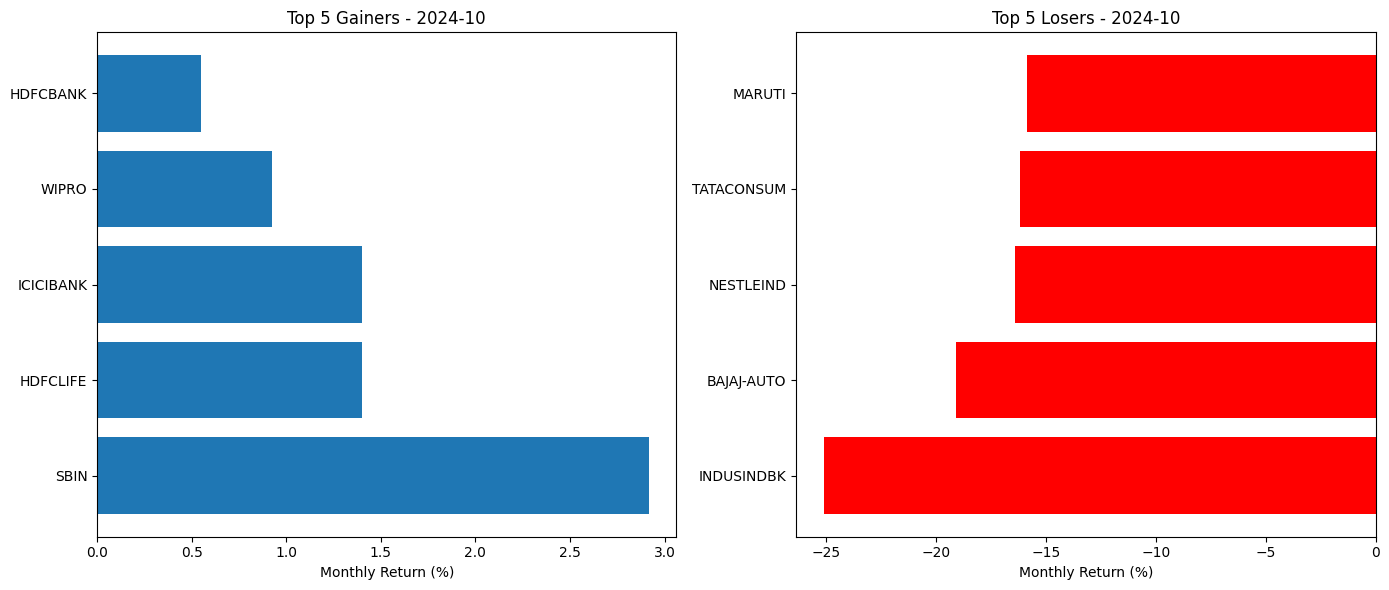

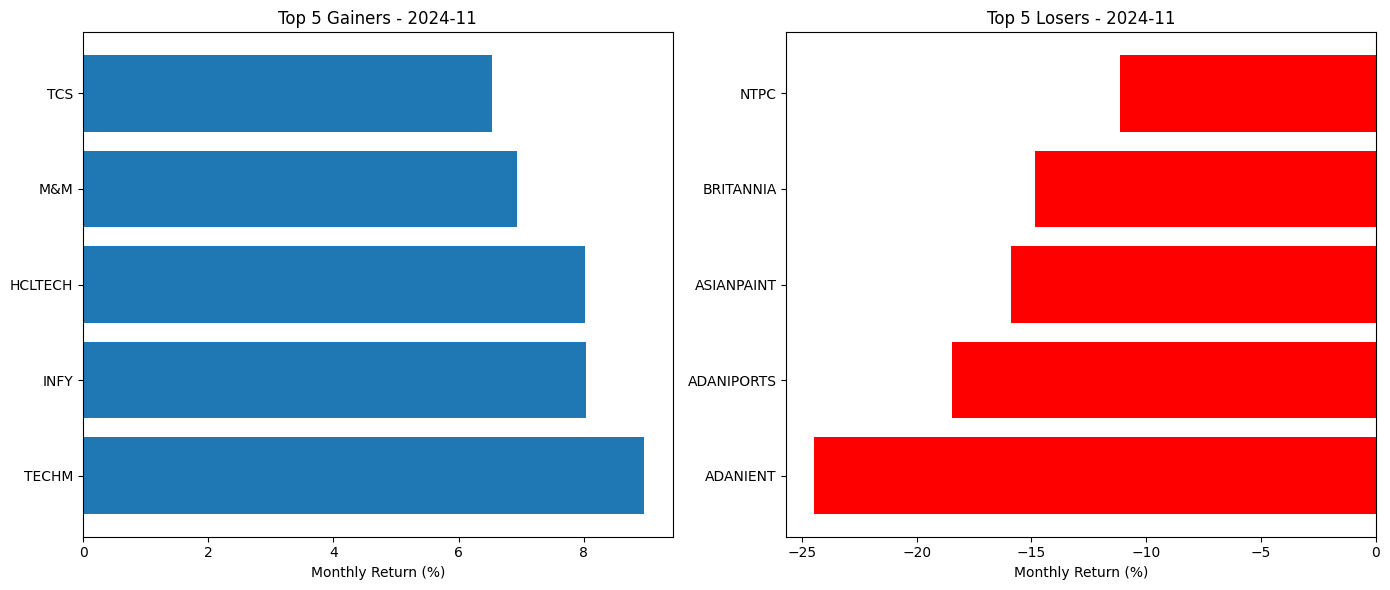

In [30]:
unique_months = monthly['Month'].unique()

    # Create 12 charts (one per month)
for month in unique_months:
        df_month = monthly[monthly['Month'] == month]

        top5_gainers = df_month.nlargest(5, 'Monthly_Return')
        top5_losers = df_month.nsmallest(5, 'Monthly_Return')

        # ---- Plot ----
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Gainers
        axes[0].barh(top5_gainers['Ticker'], top5_gainers['Monthly_Return'])
        axes[0].set_title(f"Top 5 Gainers - {month}")
        axes[0].set_xlabel("Monthly Return (%)")

        # Losers
        axes[1].barh(top5_losers['Ticker'], top5_losers['Monthly_Return'], color='red')
        axes[1].set_title(f"Top 5 Losers - {month}")
        axes[1].set_xlabel("Monthly Return (%)")

        plt.tight_layout()
        plt.show()
